In [1]:
!pip install finance-datareader

In [3]:
#!pip install xgboost
#!pip install tensorflow
#!pip install keras

### 라이브러리 로딩

In [4]:
# 필요한 부분 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# DL
import tensorflow as tf

# ML
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


from keras.models import Sequential
from keras.layers import Conv1D,LSTM, Dense
from keras.backend import clear_session
from keras.optimizers import Adam

from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import mlflow
import mlflow.keras

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'



### 함수 만들기

In [6]:
# TensorFlow Dataset을 활용한 시퀸스 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## mlflow 추적 준비

- SQLite에 기록
  - mlflow.db가 생성됨

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### 실험 생성

In [8]:
exp_id = mlflow.create_experiment("stock_prediction")
exp_id

2023/11/20 07:57:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/20 07:57:02 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

'1'

### 모델링 & Tracking

In [22]:
stock_code = 'KS11'

In [45]:
stock_code = 'KS11'
def preprocess_data(stock_code, window_size=20, batch_size=32):
    # 데이터 수집 및 전처리를 위한 stock_code, window_size, batch_size 인수 사용
    STOCK_CODE = stock_code
    WINDOW_SIZE = window_size
    BATCH_SIZE = batch_size
    
    stock = fdr.DataReader(STOCK_CODE, '2013')
    # stock['Year'] = stock.index.year
    # stock['Month'] = stock.index.month
    # stock['Day'] = stock.index.day

    scaler = MinMaxScaler()
    scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaled = scaler.fit_transform(stock[scale_cols])
    df = pd.DataFrame(scaled, columns=scale_cols)

    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Close']), df['Close'], test_size=0.2, random_state=20, shuffle=False)

    train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
    test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

    return train_data, test_data

In [43]:
# stock_code = 'KS11'
# stock = fdr.DataReader(stock_code, '2013')

# scaler = MinMaxScaler()
# scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# scaled = scaler.fit_transform(stock[scale_cols])
# df = pd.DataFrame(scaled, columns=scale_cols)

# print(df.columns)

# # x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Close', 'UpDown', 'Comp','Amount', 'MarCap']), df['Close'], test_size=0.2, random_state=20, shuffle=False)

# # print(x_train)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


* 평가지표

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

* 첫번째 모델

In [46]:
stock_code = 'KS11'
#첫번째 모델
with mlflow.start_run(experiment_id=exp_id, run_name=f'{stock_code}_dl_autolog'):
    mlflow.keras.autolog()

    # Preprocess the data using the provided stock code
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    train_data, test_data = preprocess_data(stock_code, WINDOW_SIZE, BATCH_SIZE)

    # Model design and compilation
    model = Sequential([
        Conv1D(filters=64, kernel_size=10, padding="same", activation="relu", input_shape=[WINDOW_SIZE, 1]),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(loss=Huber(), optimizer=Adam(0.0005))

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Training
    history = model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[early_stopping]).history

    # Log the model
    mlflow.keras.log_model(model, "model", registered_model_name= "stock_prediction")

    # Disable autolog
    mlflow.keras.autolog(disable=True)

Epoch 1/50
67/67 [==============================] - 7s 60ms/step - loss: 0.0062 - val_loss: 3.9280e-04
Epoch 2/50
67/67 [==============================] - 2s 31ms/step - loss: 2.5108e-04 - val_loss: 3.9680e-04
Epoch 3/50
67/67 [==============================] - 1s 17ms/step - loss: 2.3530e-04 - val_loss: 4.8104e-04
Epoch 4/50
67/67 [==============================] - 1s 11ms/step - loss: 2.3600e-04 - val_loss: 3.5291e-04
Epoch 5/50
67/67 [==============================] - 1s 12ms/step - loss: 2.2603e-04 - val_loss: 3.4255e-04
Epoch 6/50
67/67 [==============================] - 1s 11ms/step - loss: 2.1619e-04 - val_loss: 4.6173e-04
Epoch 7/50
67/67 [==============================] - 1s 19ms/step - loss: 2.0644e-04 - val_loss: 3.7047e-04
Epoch 8/50
67/67 [==============================] - 1s 11ms/step - loss: 2.0558e-04 - val_loss: 3.1519e-04
Epoch 9/50
67/67 [==============================] - 1s 15ms/step - loss: 1.9111e-04 - val_loss: 2.9929e-04
Epoch 10/50
67/67 [======================

WARNI [tensorflow] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000013EDB6CB490> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 512ms/step


WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\grace\AppData\Local\Temp\tmpeggno8ru\model\data\model\assets


INFO  [tensorflow] Assets written to: C:\Users\grace\AppData\Local\Temp\tmpeggno8ru\model\data\model\assets
2023/11/20 09:15:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\grace\AppData\Local\Temp\tmp28vb6rgw\model\data\model\assets


INFO  [tensorflow] Assets written to: C:\Users\grace\AppData\Local\Temp\tmp28vb6rgw\model\data\model\assets
Registered model 'stock_prediction' already exists. Creating a new version of this model...
2023/11/20 09:15:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: stock_prediction, version 3
Created version '3' of model 'stock_prediction'.


* 두번째 모델

In [47]:
stock_code = 'KS11'
# 두 번째 실행   
with mlflow.start_run(experiment_id=exp_id, run_name=f'{stock_code}_dl_autolog_2'):
    mlflow.keras.autolog()

#모델 설계 및 컴파일
    model2 = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=64, kernel_size=10,
        padding="same",
        activation="relu",
        input_shape=[WINDOW_SIZE, 1]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1) ])
    # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
    loss = Huber()
    optimizer = Adam(0.0005)
    model2.compile(loss=Huber(), optimizer= optimizer)
    # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
    earlystopping = EarlyStopping(monitor='val_loss', patience=10)
#학습
    history = model2.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[earlystopping]).history
#모델 등록 (best 모델 기록하기)
    mlflow.keras.log_model(model2, "model2",  registered_model_name="stock_prediction")
#autolog 종료
    mlflow.keras.autolog(disable = True)

Epoch 1/50
67/67 [==============================] - 4s 17ms/step - loss: 0.0079 - val_loss: 5.0791e-04
Epoch 2/50
67/67 [==============================] - 1s 11ms/step - loss: 2.9498e-04 - val_loss: 4.4538e-04
Epoch 3/50
67/67 [==============================] - 1s 12ms/step - loss: 2.7287e-04 - val_loss: 4.2082e-04
Epoch 4/50
67/67 [==============================] - 1s 16ms/step - loss: 2.6874e-04 - val_loss: 4.9082e-04
Epoch 5/50
67/67 [==============================] - 1s 19ms/step - loss: 2.4280e-04 - val_loss: 3.7239e-04
Epoch 6/50
67/67 [==============================] - 1s 11ms/step - loss: 2.2416e-04 - val_loss: 3.4018e-04
Epoch 7/50
67/67 [==============================] - 1s 13ms/step - loss: 2.2045e-04 - val_loss: 3.5945e-04
Epoch 8/50
67/67 [==============================] - 2s 26ms/step - loss: 2.0657e-04 - val_loss: 4.6562e-04
Epoch 9/50
67/67 [==============================] - 2s 28ms/step - loss: 1.7996e-04 - val_loss: 2.7452e-04
Epoch 10/50
67/67 [======================

WARNI [tensorflow] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000013EE4EBD510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 457ms/step


WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, lstm_cell_5_layer_call_fn, lstm_cell_5_layer_call_and_return_conditional_losses while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\grace\AppData\Local\Temp\tmp29awlrwo\model\data\model\assets


INFO  [tensorflow] Assets written to: C:\Users\grace\AppData\Local\Temp\tmp29awlrwo\model\data\model\assets
2023/11/20 09:18:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, lstm_cell_5_layer_call_fn, lstm_cell_5_layer_call_and_return_conditional_losses while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\grace\AppData\Local\Temp\tmpcofort8p\model\data\model\assets


INFO  [tensorflow] Assets written to: C:\Users\grace\AppData\Local\Temp\tmpcofort8p\model\data\model\assets
Registered model 'stock_prediction' already exists. Creating a new version of this model...
2023/11/20 09:18:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: stock_prediction, version 4
Created version '4' of model 'stock_prediction'.


## 모델링
* mlflow.start_run(experiment_id = exp1, run_name = `모델링의 특성이 반영된 이름`)
* autolog로 로깅
* 튜닝된 모델은 수동 로깅
    * 모델 이름 : `StockPrediction`

### mlflow 서버 실행

* 터미널을 열고
* 경로 확인 : 현재 폴더 위치
* 아래 명령어 실행  
`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts`

### 학습 곡선

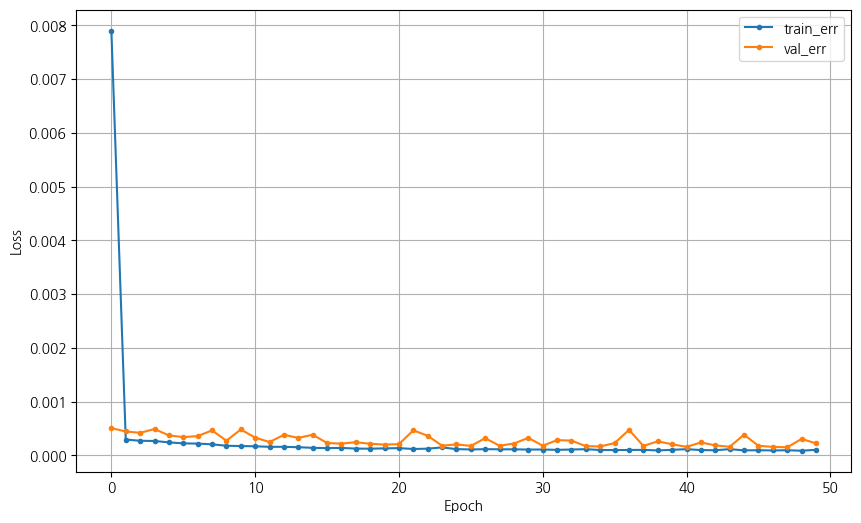

In [48]:
dl_history_plot(history)

### 각 버전별 불러오기

* 특정 버전 모델
* 최근 버전 모델
* 운영 모델

### model Loading 하기
*mlflow uri를 setting해야 모델 로딩도 가능!

In [ ]:
# mlflow_uri = "sqlite:///mlflow.db"
# mlflow.set_tracking_uri(mlflow_uri)

In [49]:
# 버전으로 가져오기
# model_uri = "models:/CarSeat/1" 
# model1 = mlflow.keras.load_model(model_uri)

# 최신버전으로 가져오기
# model_uri = "models:/test/1" 
# model1 = mlflow.keras.load_model(model_uri)

# 운영중인 버전 가져오기
model_uri = "models:/stock_prediction/production" 
model_p = mlflow.keras.load_model(model_uri)

### 예측 및 검증

In [50]:

pred = model_p.predict(test_data)

17/17 [==============================] - 2s 37ms/step


In [53]:
print(test_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [32]:
pred2 = model2.predict(test_data)
print(pred2)

WARNI [tensorflow] 5 out of the last 47 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000240FCC82200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 [==============================] - 1s 13ms/step
[[0.35148448]
 [0.35760337]
 [0.35913795]
 [0.36393452]
 [0.36712694]
 [0.36479038]
 [0.36265436]
 [0.3616531 ]
 [0.36194956]
 [0.3679402 ]
 [0.37815306]
 [0.3840563 ]
 [0.383117  ]
 [0.39208898]
 [0.40818173]
 [0.41740486]
 [0.42217344]
 [0.42621982]
 [0.42827365]
 [0.43166506]
 [0.43701094]
 [0.44198254]
 [0.44091177]
 [0.44188106]
 [0.44281566]
 [0.4422245 ]
 [0.4368233 ]
 [0.43159813]
 [0.43160528]
 [0.43020576]
 [0.42908278]
 [0.42520595]
 [0.41904828]
 [0.41525713]
 [0.41496965]
 [0.41459802]
 [0.41678262]
 [0.41489768]
 [0.4112449 ]
 [0.41369066]
 [0.4151859 ]
 [0.41954002]
 [0.41525424]
 [0.4136569 ]
 [0.414659  ]
 [0.41512462]
 [0.41308272]
 [0.4092496 ]
 [0.40714177]
 [0.40569264]
 [0.40159816]
 [0.3946405 ]
 [0.39352316]
 [0.40064496]
 [0.40394837]
 [0.40636754]
 [0.41232792]
 [0.41734603]
 [0.42061746]
 [0.41815597]
 [0.41508874]
 [0.41099858]
 [0.4259168 ]
 [0.45009118]
 [0.46013552]
 [0.46407312]
 [0.46441182]
 [0.456692

### 예측 데이터 시각화


In [34]:
np.asarray(y_test)[20:]

array([0.36296975, 0.36067828, 0.37442713, 0.36984418, 0.3583868 ,
       0.36067828, 0.36296975, 0.36296975, 0.37855179, 0.39367553,
       0.38955087, 0.37901008, 0.41338222, 0.43446379, 0.42621448,
       0.42850596, 0.43583868, 0.4335472 , 0.44087993, 0.44912924,
       0.45233731, 0.44087993, 0.45187901, 0.45004583, 0.44821265,
       0.4335472 , 0.43446379, 0.44271311, 0.43583868, 0.43629698,
       0.42758937, 0.41979835, 0.42071494, 0.42575619, 0.42208983,
       0.43033914, 0.41796517, 0.4152154 , 0.42896425, 0.4243813 ,
       0.43492209, 0.41109074, 0.42346471, 0.42346471, 0.42392301,
       0.41429881, 0.41200733, 0.41200733, 0.41154904, 0.40054995,
       0.39092576, 0.40284143, 0.42117324, 0.41109074, 0.41613199,
       0.42942255, 0.43033914, 0.42988084, 0.41796517, 0.41796517,
       0.41063245, 0.46516957, 0.48991751, 0.4715857 , 0.47571036,
       0.47341888, 0.45187901, 0.46287809, 0.43996334, 0.43583868,
       0.46837764, 0.47112741, 0.4715857 , 0.4619615 , 0.46287

In [35]:
pred

array([[0.35165554],
       [0.3572996 ],
       [0.36140475],
       [0.36729637],
       [0.37134525],
       [0.37111667],
       [0.37101206],
       [0.37093827],
       [0.37062764],
       [0.37428847],
       [0.38161066],
       [0.38713756],
       [0.38874862],
       [0.39715284],
       [0.4098169 ],
       [0.41909328],
       [0.4260488 ],
       [0.43234795],
       [0.4364498 ],
       [0.44077238],
       [0.44584405],
       [0.45041457],
       [0.45085725],
       [0.45254123],
       [0.4532359 ],
       [0.45278928],
       [0.44842792],
       [0.44394502],
       [0.4420981 ],
       [0.4395015 ],
       [0.43740693],
       [0.43360546],
       [0.4282696 ],
       [0.4241231 ],
       [0.42234516],
       [0.4206566 ],
       [0.42146304],
       [0.419854  ],
       [0.41747406],
       [0.41882265],
       [0.41979954],
       [0.42318287],
       [0.42079416],
       [0.42057273],
       [0.42090282],
       [0.42143497],
       [0.41969085],
       [0.417

In [52]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

#print("내일 SEC 주가 :", df.Close[-1] * pred[-1] / dfy.Close[-1], 'KRW')

NameError: name 'y_test' is not defined

<Figure size 1200x900 with 0 Axes>

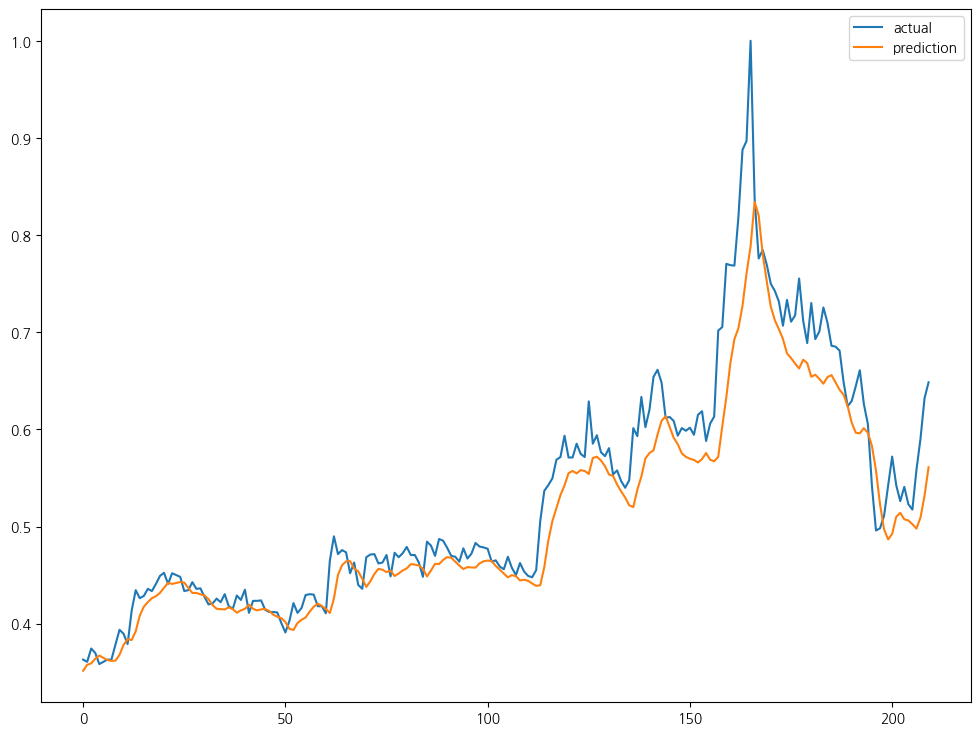

In [33]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred2, label='prediction')
plt.legend()
plt.show()